# A Brief Introduction to harold

``harold`` is a control systems toolbox that provides essential control engineering tools. In this notebook, we cover the basics of working with models and standard operations using them.

Let us first import the common libraries that will be used throughout this document. Star importing is generally frowned upon due to possible name clashes however since we are exclusively working with ``harold`` this simplifies the coding.

In [1]:
import numpy as np
from harold import *
import matplotlib.pyplot as plt

## Creating models

``harold`` defines two classes to represent the dynamic models, namely, ``Transfer`` and ``State`` classes. The usage is straightforward. Since NumPy arrays are a bit laborious to enter, the inputs are designed to be as flexible as possible. We are going to define a few models for sake of demonstration

$$
G_1 = \frac{z-1}{z^3-zs^2+z},\quad 
G_2 = \begin{bmatrix}\frac{1}{s+2}&\frac{s+3}{s^2+s-4}\\ 0&\frac{s+2}{s-3}\end{bmatrix},\quad
G_3 = \left[\begin{array}{cc|c}0&1&0\\-2&-0.5&1\\\hline 0&3.5&1 \end{array}\right],\quad
G_4 = \left[\begin{array}{ccc|cc}-4&-2&2&1&1\\0&-5&2&0&1\\4&-3&-4&2&-1\\\hline -1&5&2&0&0\end{array}\right]
$$

In [2]:
G1 = Transfer([1, -1],[1, -2, 1, 0], dt=0.1) # discrete
G2 = Transfer([[1, [1, 3]],[0, [1, 2]]], [[[1, 2], [1, 0, -4]],[1, [1, -3]]])
G3 = State([[0, 1], [-0.1, -0.5]], [[0], [1]], [0, 3.5], 1, dt=0.1) # discrete
G4 = State([[-4, -2, 2], [0, -5, 2], [4, -3, -4]], [[1, 1], [0, 1], [2, -1]], [-1, 5, 2])

Internally, the list objects are converted to NumPy arrays. Notice that when we are defining $G_4$, we skipped the $D$ matrix since it is zero. Discrete-time models can be defined with the same syntax but also adding ``dt`` keyword with a value in seconds, for example,  ``State(a, b, c, d, dt=1)``. Getting used to using keywords in Python, both improves the readability and also avoids problems such as ``State(a, b, c, 1)`` which would take ``1`` as the $D$ element instead of the sampling period.

The default ``__repr__`` method is to provide basic information about the objects however can be converted to any other custom string.

In [3]:
G1

Discrete-Time Transfer function with sampling time: 0.100 (10.000 Hz.)
 1 input and 1 output

  Poles(real)    Poles(imag)    Zeros(real)    Zeros(imag)
-------------  -------------  -------------  -------------
            0              0              1              0
            1              0
            1              0


Now, we can directly identify the pole zero structure right away. Though MIMO state representations should be preferred exclusively, MIMO transfer models explicitly require a list of lists structure. Additionally, common denominators can also be given and it will be expanded to every entry in the denominator list of lists, say, $$G_5 = \frac{1}{s^2+5s+1}\begin{bmatrix}s+1&2\\s+3&4\end{bmatrix}$$

In [4]:
G5 = Transfer([[[1, 1], 2], [[1, 3], 4]], [1, 5, 1])
print('Numerator :\n', G5.num, '\nDenominator :\n', G5.den)

Numerator :
 [[array([[1., 1.]]), array([[2.]])], [array([[1., 3.]]), array([[4.]])]] 
Denominator :
 [[array([[1., 5., 1.]]), array([[1., 5., 1.]])], [array([[1., 5., 1.]]), array([[1., 5., 1.]])]]


One typical inconvenience entering ``State`` models is that, it is much easier to type the whole array $\begin{bmatrix}A&B\\C&D\end{bmatrix}$ and slice the individual arrays. However, this needs the extra slice indices which might be also laborious. The ``matrix_slice()`` function is provided for this purpose. Hence, suppose that the model data for $G_4$ above is given as an array already. Then creating $G_4$ is basically providing the slices and using the ``*``-argument expansion of Python.

In [5]:
M = np.array([[-4, -2, 2, 1, 1], [0, -5, 2, 0, 1], [4, -3, -4, 2, -1], [-1, 5, 2, 0, 0]])
G4 = State(*matrix_slice(M, corner_shape=[3, 3], corner='nw'))
G4.matrices

(array([[-4., -2.,  2.],
        [ 0., -5.,  2.],
        [ 4., -3., -4.]]), array([[ 1.,  1.],
        [ 0.,  1.],
        [ 2., -1.]]), array([[-1.,  5.,  2.]]), array([[0., 0.]]))

We could have sliced the array based on the shape of the ``C`` array and arrive at the same result

In [6]:
M = np.array([[-4, -2, 2, 1, 1],
              [0, -5, 2, 0, 1],
              [4, -3, -4, 2, -1],
              [-1, 5, 2, 0, 0]])
G4 = State(*matrix_slice(M, corner_shape=[1, 3], corner='sw'))

Further properties can be accessed via the typical dot syntax

In [7]:
print('Polynomials of G1:', G1.polynomials)
print('Model data of G3:','-'*15, G3.matrices, sep='\n')
print('A matrix of G4:', '-'*15, G4.a, sep='\n')

Polynomials of G1: (array([[ 1., -1.]]), array([[ 1., -2.,  1.,  0.]]))
Model data of G3:
---------------
(array([[ 0. ,  1. ],
       [-0.1, -0.5]]), array([[0.],
       [1.]]), array([[0. , 3.5]]), array([[1.]]))
A matrix of G4:
---------------
[[-4. -2.  2.]
 [ 0. -5.  2.]
 [ 4. -3. -4.]]


## Conversions of Models

In order to convert one model representation to another, the relevant functions are `transfer_to_state()` and `state_to_transfer()`. Notice that, typically the conversion from a Transfer model to a State model leads to a nonminimal representations.

In [8]:
H = transfer_to_state(G2)
J = state_to_transfer(G3)

In [9]:
H


 Continous-time state represantation
4 states, 2 inputs, and 2 outputs
  Poles(real)    Poles(imag)    Zeros(real)    Zeros(imag)
-------------  -------------  -------------  -------------
           -2              0             -2              0
            3              0             -2              0
            2              0              2              0
           -2              0


In [10]:
J

Discrete-Time Transfer function with sampling time: 0.100 (10.000 Hz.)
 1 input and 1 output

  Poles(real)    Poles(imag)    Zeros(real)    Zeros(imag)
-------------  -------------  -------------  -------------
        -0.25       0.193649     -0.0251582              0
        -0.25      -0.193649     -3.97484                0


## Minimal Realization

The minimality is an essential property of any representations for reliable computations and hence we can use ``minimal_realization()`` function. This function uses a distance metric to the closest rank-deficient matrix pencil for State models and a straightforward walk-over the poles and zeros for Transfer representations. As usual, the tolerance for decision can be adjusted.

Note that, MIMO poles and zeros don't necessarily cancel each other even though the values are identical. This is because for MIMO representations pole and zero directionalities can be different. Let's see this for the representation $H$ we have obtained above.

In [11]:
Hm = minimal_realization(H)
Hm


 Continous-time state represantation
3 states, 2 inputs, and 2 outputs
  Poles(real)    Poles(imag)    Zeros(real)    Zeros(imag)
-------------  -------------  -------------  -------------
           -2              0              2              0
            2              0             -2              0
            3              0


# Discretization and undiscretization

Discretization of models is more of an art than science. Though the methods are quite sound, selecting the right method and the relevant sampling period is up to designer's choice.

In [12]:
G6 = Transfer([1], [1, 1.4, 1])
G6d = discretize(G6, dt=0.3, method='zoh')
G6d

Discrete-Time Transfer function with sampling time: 0.300 (3.333 Hz.)
 1 input and 1 output

  Poles(real)    Poles(imag)    Zeros(real)    Zeros(imag)
-------------  -------------  -------------  -------------
     0.792052       0.172336      -0.869152              0
     0.792052      -0.172336


Current known discretization methods are:

In [13]:
from harold._global_constants import _KnownDiscretizationMethods as km
print(*km, sep='\n')

bilinear
tustin
zoh
foh
forward difference
forward euler
forward rectangular
backward difference
backward euler
backward rectangular
lft
>>
<<


The ``forward xxx``, ``backward xxx`` are aliases of ``>>`` and ``<<``. Similarly, ``bilinear`` is an alias of ``tustin``. 

Moreover, converting the models back and forth after each manipulation necessitates some sort of a memory of what has happened before. For this purpose, ``harold`` encodes the method of discretization into the model such that when converted back the discretization information is searched first and then if not found, the defaults are used. Let's start by using $G_3$ above which we have not provided any method but for $G_{6d}$ the default method is already implemented.

In [14]:
G3.DiscretizedWith is None

True

In [15]:
G6d.DiscretizedWith

'zoh'

Now, if we convert back these models, $G_3$ will be converted using the default method ``tustin`` however $G_{6d}$ will be converted via zero-order hold method. Had this information not present, the resulting continuous model would be slightly different than what we started with.

In [16]:
G6dcz = undiscretize(G6d)
G6dcz

Continous-Time Transfer function
 1 input and 1 output

  Poles(real)    Poles(imag)  Zeros(real)    Zeros(imag)
-------------  -------------  -------------  -------------
         -0.7       0.714143
         -0.7      -0.714143


In [17]:
G6dct = undiscretize(G6d, method='tustin')
G6dct

Continous-Time Transfer function
 1 input and 1 output

  Poles(real)    Poles(imag)    Zeros(real)    Zeros(imag)
-------------  -------------  -------------  -------------
    -0.705414       0.708951        6.66667              0
    -0.705414      -0.708951      -95.2327               0


## Model algebra

Basic algebraic operations and feedback operations are implemented via typical ``*,+,-,@`` and ``feedback()`` function. The shape and sampling time compatibility is checked before the operations and errors are raised in case of mismatches.

One exception is the operation with a SISO model over a MIMO model. For example, $G_1$ is a SISO model and $G_3$ is a sampling time matching MIMO model, hence following is allowed which multiplies each entry of $G_3$ with $G_1$. For multiplication of MIMO models matrix multiplication rules and hence matrix multiplication operator ``@`` is followed.

In [18]:
G1 * G3

Discrete-Time state representation with sampling time: 0.100 (10.000 Hz.)
5 states, 1 input, and 1 output
  Poles(real)    Poles(imag)    Zeros(real)    Zeros(imag)
-------------  -------------  -------------  -------------
        -0.25       0.193649     -0.0251582              0
        -0.25      -0.193649     -3.97484                0
         0          0             1                      0
         1          0
         1          0


In [19]:
G4 @ G2


 Continous-time state represantation
7 states, 2 inputs, and 1 output
  Poles(real)    Poles(imag)  Zeros(real)    Zeros(imag)
-------------  -------------  -------------  -------------
     -6.76735        0
     -3.11633        1.45258
     -3.11633       -1.45258
     -2              0
      3              0
      2              0
     -2              0


In [20]:
CL = feedback(G3, G1)
CL_min = minimal_realization(CL)
CL

Discrete-Time state representation with sampling time: 0.100 (10.000 Hz.)
5 states, 1 input, and 1 output
  Poles(real)    Poles(imag)    Zeros(real)    Zeros(imag)
-------------  -------------  -------------  -------------
   -1.30016          0           -3.97484                0
    0.912951         1.46766     -0.0251582              0
    0.912951        -1.46766     -0                      0
    1                0            1                      0
   -0.0257453        0            1                      0


We observe that there is a pole/zero cancellation at `1.` which is removed afterwards.

In [21]:
CL_min

Discrete-Time state representation with sampling time: 0.100 (10.000 Hz.)
4 states, 1 input, and 1 output
  Poles(real)    Poles(imag)    Zeros(real)    Zeros(imag)
-------------  -------------  -------------  -------------
   -1.30016          0          1.94064e-14              0
   -0.0257453        0         -0.0251582                0
    0.912951         1.46766    1                        0
    0.912951        -1.46766   -3.97484                  0


## Basic Plotting Functionality

The typical plots that are needed are already available. For frequency domain plotting, the default units are Hz and powers of ten for amplitudes. Motivation for these choices can be found in the book [Feedback Systems](https://press.princeton.edu/titles/8701.html)

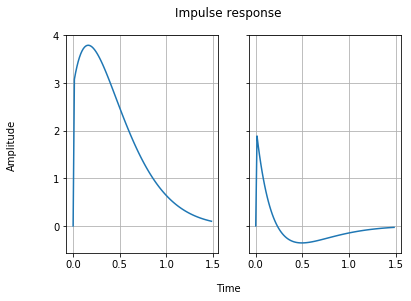

In [22]:
impulse_response_plot(G4);

The discrete-time plant plots are automatically drawn as stairs.

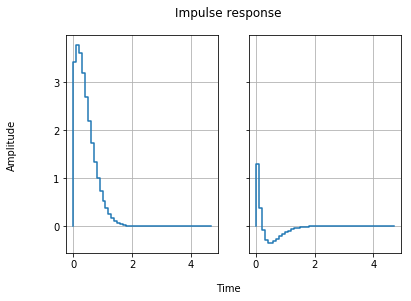

In [23]:
G4_d = discretize(G4, 0.1, method='zoh')
impulse_response_plot(G4_d);

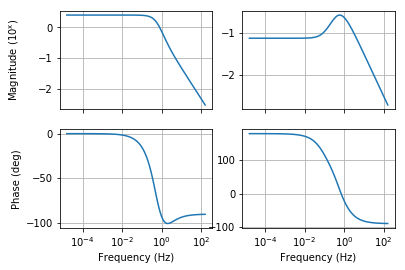

In [24]:
bode_plot(G4);

The plot units can be changed via the keywords available

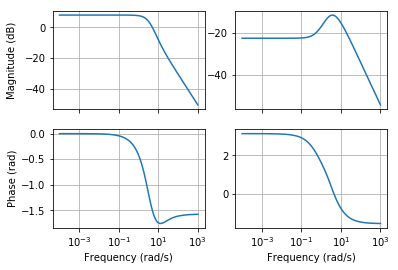

In [25]:
bode_plot(G4, use_db=True, use_hz=False, use_degree=False);

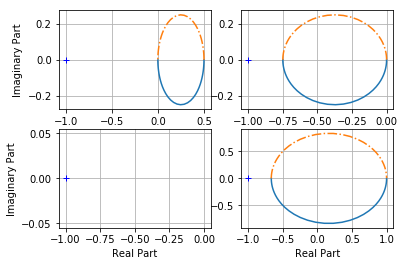

In [26]:
nyquist_plot(G2);

# An LQR example

Just to demonstrate the convenience, let's pickup the first section of the LQR example *Inverted Pendulum: State-Space Methods for Controller Design* from the classic [Control Tutorials for MATLAB](http://ctms.engin.umich.edu/CTMS/index.php?example=InvertedPendulum&section=ControlStateSpace)

The system is Kalman controllable: True
Controller K gains :  [[-1.         -1.65671003 18.6853959   3.45943818]]


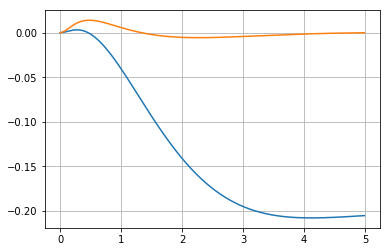

In [27]:
# Define some parameters
M, m, b, I, g, l = 0.5, 0.2, 0.1, 0.006, 9.8, 0.3
p = I*(M+m) + M*m*l**2  #denominator for the A and B matrices

A = np.array([[0, 1, 0, 0], [0, -(I+m*l**2)*b/p, (m**2*g*l**2)/p, 0],[0, 0, 0, 1], [0, -(m*l*b)/p, m*g*l*(M+m)/p, 0]])
B = np.array([[0], [(I+m*l**2)/p], [0], [m*l/p]])
C = np.array([[1, 0, 0, 0], [0, 0, 1, 0]])

sys_ss = State(A,B,C)
print('The system is Kalman controllable:', is_kalman_controllable(sys_ss))

Q = C.T @ C
K, X, eigs = lqr(sys_ss, Q)  # R = 1 if omitted
print('Controller K gains : ', K)
sys_cl = State(A-B@K, B, C)

t = np.arange(0, 5, 0.01)
r =0.2*np.ones(len(t))
y, t = simulate_linear_system(sys_cl, u=r, t=t)
fig, ax = plt.subplots(1, 1)
ax.plot(t,y);
ax.grid(which='both')

Now, the weights on the position states are increased 

New Controller gains :  [[-70.71067812 -37.83445399 105.52978192  20.92384375]]


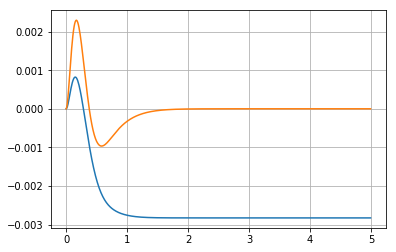

In [28]:
Q[[0, 2], [0, 2]] = [5000, 100]
K, X, eigs = lqr(sys_ss, Q)
print('New Controller gains : ', K)
sys_cl = State(A-B@K, B, C)
y, t = simulate_linear_system(sys_cl, u=r, t=t)
fig, ax = plt.subplots(1, 1)
ax.plot(t,y);
ax.grid(which='both')

There are many other functions already available such as $H_\infty,H_2$ norms, LQR design with output weights, staircase/hessenberg forms, kalman tests and so on. Please don't hesitate to provide feedback by opening issues or submitting PRs to the code repository on Github. That would actually shape where the development time is going to be spent on.

[``harold`` on Github](https://github.com/ilayn/harold)

I am especially interested in the pain points of the current software tools for control such that we can redesign the API and make the software more useful.